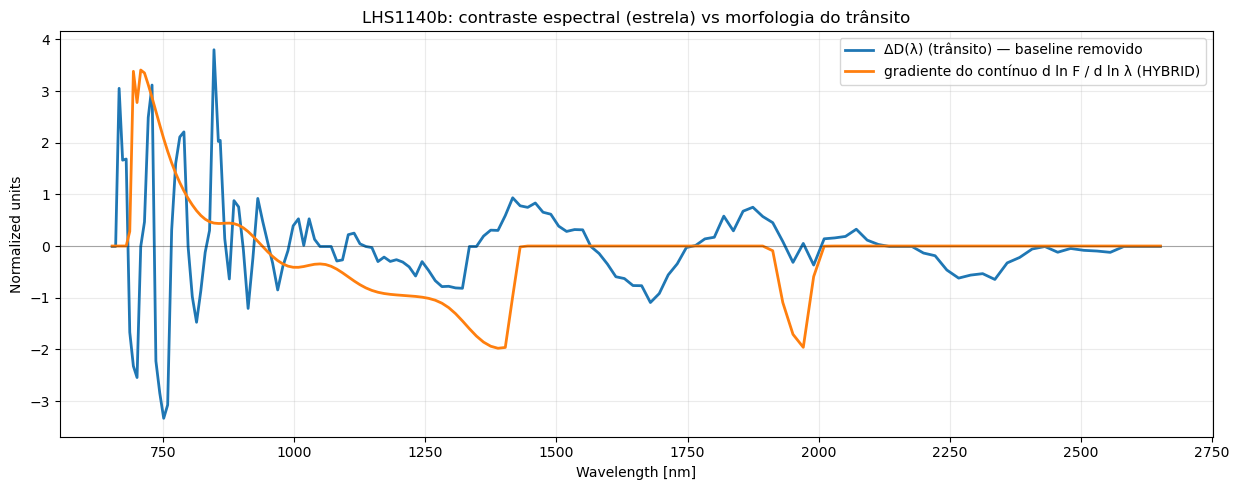

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Overlay diagnóstico:
- Gradiente espectral do contínuo estelar (d logF / d logλ), vindo do PHOENIX HYBRID
- vs. variação do espectro de trânsito ΔD(λ) (tirando o “baseline” suave)

Como usar:
1) Rode seu GRID para gerar o arquivo simulation_results_<TARGET>.txt
2) Ajuste as constantes abaixo (TARGET, Teff, etc.) p/ bater com o GRID
3) Execute este script (python plot_contrast_vs_transit.py)
"""

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from phoenix_sed import phoenix_continuum_hybrid_global, phoenix_flux_interp_um

# ======================================================
# 1) CONFIGURAÇÃO BÁSICA — MESMO SET DO SEU GRID
# ======================================================
TARGET = "LHS1140b"
Teff   = 3096.0
FEH    = 0.0

# knobs do híbrido — copie do GRID
R_BLUR      = 25.0
HYB_ALPHA   = 0.50
HYB_BETA    = 0.94
HYB_CAP     = 0.99
HYB_R_POST  = 100.0

# caminho do resultado do GRID
IN_TXT = f"simulation_results_{TARGET}.txt"
LAM_HR = np.linspace(0.40, 2.80, 22000)  # µm

# ======================================================
# 2) FUNÇÕES AUXILIARES
# ======================================================
def running_median(y, win):
    y = np.asarray(y, float)
    w = int(max(3, win//2*2+1))
    pad = w//2
    yp = np.pad(y, (pad, pad), mode="edge")
    out = np.empty_like(y)
    for i in range(len(y)):
        out[i] = np.nanmedian(yp[i:i+w])
    return out

def dlogF_dloglam(lam_um, F):
    lam = np.asarray(lam_um, float)
    F   = np.asarray(F, float)
    m = np.isfinite(lam) & np.isfinite(F) & (lam > 0) & (F > 0)
    zl = np.log(lam[m])
    zf = np.log(F[m])
    dz  = np.gradient(zl)
    dzf = np.gradient(zf)
    g = np.full_like(lam, np.nan, float)
    g[m] = dzf/dz
    return g

def standardize(x):
    x = np.asarray(x, float)
    m = np.nanmean(x)
    s = np.nanstd(x)
    s = s if np.isfinite(s) and s > 0 else 1.0
    return (x - m) / s

# ======================================================
# 3) CONTÍNUO HYBRID E GRADIENTE ESPECTRAL
# ======================================================
F_cont = phoenix_continuum_hybrid_global(
    LAM_HR, T=Teff, feh=FEH,
    R_blur=R_BLUR,
    alpha_mix=HYB_ALPHA,
    beta_env=HYB_BETA,
    cap_env=HYB_CAP,
    R_post=HYB_R_POST
)

G_hr = dlogF_dloglam(LAM_HR, F_cont)
G_hr = running_median(G_hr, 101)

# ======================================================
# 4) LEITURA DO ESPECTRO DE TRÂNSITO
# ======================================================
cols = ["f_spot","tempSpot","f_facula","tempFacula","wavelength","D_lambda"]
df = pd.read_csv(IN_TXT, comment="#", header=None, names=cols)

# força tipo numérico e remove NaNs
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["wavelength", "D_lambda"])

# agrega por λ -> mediana
grp = (
    df.groupby("wavelength", as_index=False)["D_lambda"]
      .median(numeric_only=True)
      .sort_values("wavelength")
)
lam_nm = grp["wavelength"].to_numpy()
D_ppm  = grp["D_lambda"].to_numpy()
lam_um_ch = lam_nm / 1000.0

# ======================================================
# 5) REMOVE O BASELINE E NORMALIZA
# ======================================================
D_base = running_median(D_ppm, 31)
dD = D_ppm - D_base

G_ch = np.interp(lam_um_ch, LAM_HR, G_hr)
dD_n = standardize(dD)
G_n  = standardize(G_ch)

# ======================================================
# 6) PLOT COMPARATIVO
# ======================================================
plt.figure(figsize=(12.5, 5.0))
plt.plot(lam_nm, dD_n, lw=2.0, label="ΔD(λ) (trânsito) — baseline removido")
plt.plot(lam_nm, G_n,  lw=2.0, label="gradiente do contínuo d ln F / d ln λ (HYBRID)")
plt.axhline(0, color='k', lw=0.8, alpha=0.3)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalized units")
plt.title(f"{TARGET}: contraste espectral (estrela) vs morfologia do trânsito")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


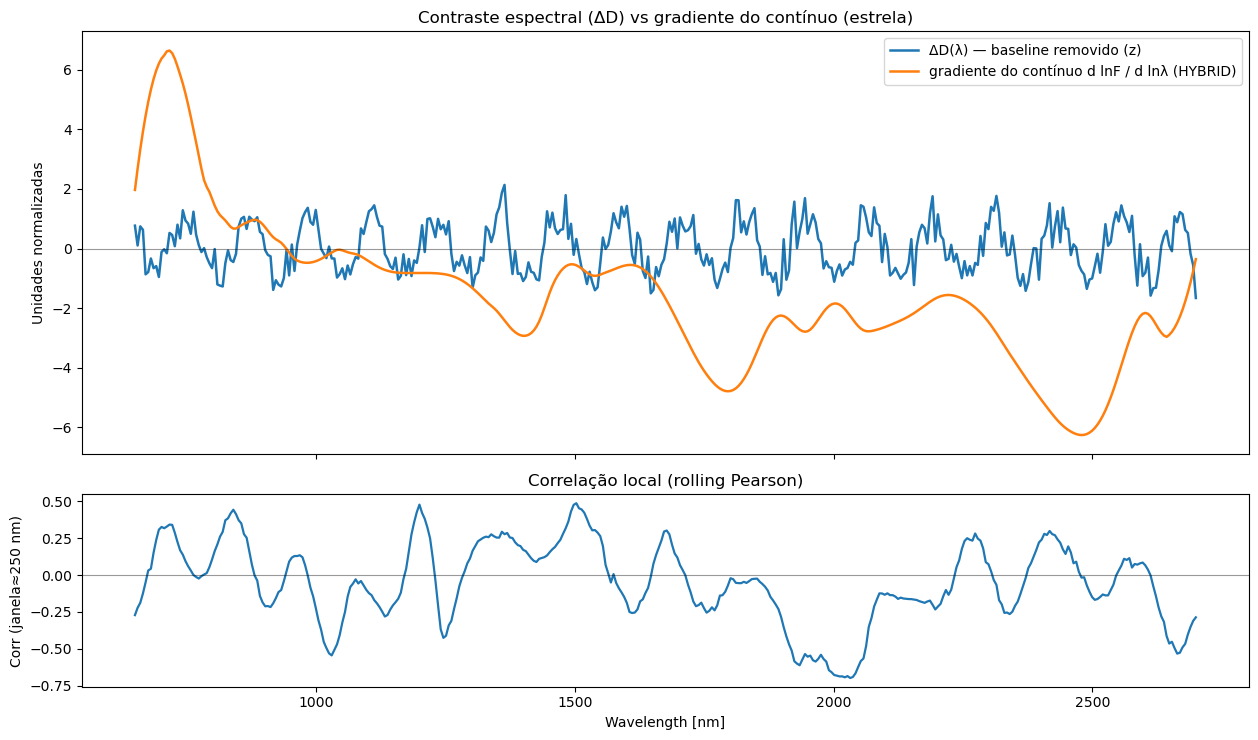

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ====== IMPORTES DO SEU PACOTE ======
from phoenix_sed import phoenix_continuum_hybrid_global
# (Se quiser usar outra SED, dá pra trocar a chamada no build_continuum.)

# ===================== KNOBS (ajustes fáceis) =====================
# Remoção de baseline da curva de trânsito (ΔD)
BASELINE_WIN_NM   = 180.0   # largura aprox. da janela Savitzky-Golay (nm)
BASELINE_POLY     = 3       # ordem do polinômio do SavGol
ZSCORE_SCALE      = "mad"   # "mad" (robusto) ou "std"

# Suavização do gradiente do contínuo (evita ruído de alta-freq)
GRAD_R_POST       = 80.0    # pós-blur em R para o contínuo (None desliga)
GRAD_SMOOTH_NM    = 120.0   # suavização final do gradiente (janela SavGol em nm)
GRAD_SMOOTH_POLY  = 2

# Parâmetros do contínuo HÍBRIDO (para gerar o gradiente)
HYB_R_BLUR        = 25.0    # ↑ deixa o contínuo mais liso
HYB_ALPHA_MIX     = 0.50    # ↓ segue envelope; ↑ segue blur
HYB_BETA_ENV      = 0.94    # piso relativo ao envelope
HYB_CAP_ENV       = 0.99    # teto relativo ao envelope
HYB_R_POST        = 100.0   # blur extra do híbrido

# Correlação deslizante
ROLL_WIN_NM       = 250.0   # janela (nm) do rolling-Pearson

# ===================== UTILIDADES =====================
def _savgol_nm(x_nm, y, win_nm, poly):
    x = np.asarray(x_nm, float)
    y = np.asarray(y, float)
    if win_nm is None or win_nm <= 0:
        return y.copy()
    # converte janela em número de pontos (ímpar)
    dx = np.median(np.diff(x[np.isfinite(x)]))
    if not np.isfinite(dx) or dx <= 0:
        return y.copy()
    win_pts = max(3, int(round(win_nm / dx)))
    if win_pts % 2 == 0:
        win_pts += 1
    win_pts = min(win_pts, len(y)-(1-(len(y)%2)))  # garante <= n e ímpar
    win_pts = max(win_pts, poly+2+(1-((poly+2)%2)))  # >= poly+2 e ímpar
    try:
        return savgol_filter(y, window_length=win_pts, polyorder=poly, mode="interp")
    except Exception:
        return y.copy()

def _zscore(y, how="mad"):
    y = np.asarray(y, float)
    if how == "std":
        s = np.nanstd(y)
        s = s if np.isfinite(s) and s > 0 else 1.0
        return (y - np.nanmedian(y)) / s
    # MAD robusto
    med = np.nanmedian(y)
    mad = np.nanmedian(np.abs(y - med))
    s = 1.4826 * mad if (np.isfinite(mad) and mad > 0) else (np.nanstd(y) or 1.0)
    return (y - med) / s

def robust_baseline(lam_nm, D_ppm):
    """Baseline suave via Savitzky-Golay."""
    return _savgol_nm(lam_nm, D_ppm, BASELINE_WIN_NM, BASELINE_POLY)

def make_deltaD(lam_nm, D_ppm_or_stack):
    """
    Se receber (nλ,) → usa direto.
    Se receber (n_runs, nλ) → usa mediana ao longo do eixo 0.
    Retorna ΔD normalizado (z-score robusto) e o baseline.
    """
    arr = np.asarray(D_ppm_or_stack, float)
    if arr.ndim == 2:
        D_med = np.nanmedian(arr, axis=0)
    else:
        D_med = arr.copy()
    base = robust_baseline(lam_nm, D_med)
    delta = D_med - base
    delta_z = _zscore(delta, ZSCORE_SCALE)
    return delta_z, base

def build_continuum(lam_um, Teff=3096.0, feh=0.0):
    """Contínuo híbrido PHOENIX com seus knobs."""
    F = phoenix_continuum_hybrid_global(
        lam_um, T=Teff, feh=feh,
        R_blur=HYB_R_BLUR,
        alpha_mix=HYB_ALPHA_MIX,
        beta_env=HYB_BETA_ENV,
        cap_env=HYB_CAP_ENV,
        R_post=HYB_R_POST
    )
    return F

def grad_logF_loglam(lam_nm, Teff=3096.0, feh=0.0):
    lam_nm = np.asarray(lam_nm, float)
    lam_um = lam_nm / 1000.0
    F = build_continuum(lam_um, Teff=Teff, feh=feh)
    # Gradiente em ln-ln
    lnlam = np.log(lam_um)
    lnF   = np.log(np.clip(F, 1e-60, None))
    dlnF  = np.gradient(lnF, lnlam)
    # Suavização final do gradiente (opcional)
    g = _savgol_nm(lam_nm, dlnF, GRAD_SMOOTH_NM, GRAD_SMOOTH_POLY)
    return g

def rolling_corr(lam_nm, y1, y2, win_nm):
    lam_nm = np.asarray(lam_nm, float)
    y1 = np.asarray(y1, float); y2 = np.asarray(y2, float)
    dx = np.median(np.diff(lam_nm))
    win_pts = max(5, int(round(win_nm / dx)))
    if win_pts % 2 == 0:
        win_pts += 1
    half = win_pts // 2
    out = np.full_like(y1, np.nan, float)
    for i in range(len(lam_nm)):
        a = max(0, i-half); b = min(len(lam_nm), i+half+1)
        s1 = y1[a:b]; s2 = y2[a:b]
        m = np.isfinite(s1) & np.isfinite(s2)
        if m.sum() >= 5:
            r = np.corrcoef(s1[m], s2[m])[0,1]
            out[i] = r
    return out

# ===================== EXEMPLO DE USO =====================
# 1) carregue sua grade espectral e profundidades (substitua por seus dados):
# lam_nm: array (nλ,), D_ppm: (nλ,) ou D_stack_ppm: (n_runs, nλ)
# Aqui, como exemplo didático, vou sintetizar algo suave:
lam_nm = np.linspace(650, 2700, 400)           # nm
# -> substitua abaixo por seus dados reais:
# D_ppm = np.loadtxt("depth_model_constR100.txt")  # por ex.
# ou uma pilha:
# D_stack_ppm = np.load("stack_constR100.npz")["D_stack"]  # shape (n_runs, nλ)

# EXEMPLO FAKE (remova ao usar seus dados):
rng = np.random.default_rng(42)
true_base = 5500 + 120*np.sin(2*np.pi*(lam_nm-600)/1600)
D_ppm = true_base + 15*np.sin(2*np.pi*lam_nm/120) + rng.normal(0,5,len(lam_nm))

# 2) constrói ΔD (azul)
deltaD, baseline = make_deltaD(lam_nm, D_ppm)

# 3) gradiente do contínuo híbrido (laranja)
g = grad_logF_loglam(lam_nm, Teff=3096.0, feh=0.0)

# 4) correlação deslizante
r_roll = rolling_corr(lam_nm, deltaD, g, ROLL_WIN_NM)

# ===================== PLOTS =====================
fig, ax = plt.subplots(2, 1, figsize=(12.6, 7.5), sharex=True,
                       gridspec_kw={"height_ratios":[2.2,1.0]})

# Painel superior: ΔD (azul) vs gradiente (laranja)
ax[0].plot(lam_nm, deltaD, lw=1.8, label="ΔD(λ) — baseline removido (z)")
ax[0].plot(lam_nm, g, lw=1.8, label="gradiente do contínuo d lnF / d lnλ (HYBRID)")
ax[0].axhline(0, color="k", lw=0.8, alpha=0.4)
ax[0].set_ylabel("Unidades normalizadas")
ax[0].legend(loc="upper right")
ax[0].set_title("Contraste espectral (ΔD) vs gradiente do contínuo (estrela)")

# Painel inferior: correlação deslizante
ax[1].plot(lam_nm, r_roll, lw=1.6)
ax[1].axhline(0, color="k", lw=0.8, alpha=0.4)
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel(f"Corr (janela≈{ROLL_WIN_NM:.0f} nm)")
ax[1].set_title("Correlação local (rolling Pearson)")

plt.tight_layout()
plt.show()

# ===================== NOTAS / DICAS =====================
# Para reduzir a amplitude de “ressonâncias” do contínuo no IR (e evitar fora-de-fase):
# - ↑ HYB_R_BLUR       (p.ex. 25→35 ou 40)
# - ↓ HYB_ALPHA_MIX    (p.ex. 0.50→0.40)  → segue mais o envelope
# - ↑ HYB_BETA_ENV     (p.ex. 0.94→0.96)  → piso mais alto (menos “mordidas”)
# - ↓ HYB_CAP_ENV      (p.ex. 0.99→0.97)  → teto menor (aplana picos)
# - ↓ HYB_R_POST       (p.ex. 100→60–80)  → pós-blur mais agressivo
# E, do lado de ΔD, ajuste:
# - BASELINE_WIN_NM / BASELINE_POLY → baseline mais liso/rigoroso
# - ZSCORE_SCALE="mad" mantém robustez contra outliers



=== Correlação por banda (Pearson) ===
 band  lo_nm  hi_nm      r  N
  VIS    650   1000  0.266 34
    Y   1000   1100 -0.777 10
    J   1100   1400  0.414 29
    H   1500   1800  0.139 29
    K   2000   2400  0.115 38
K-ext   2400   2700  0.255 30


C:\Users\vikto\AppData\Local\Temp\ipykernel_11840\755438560.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


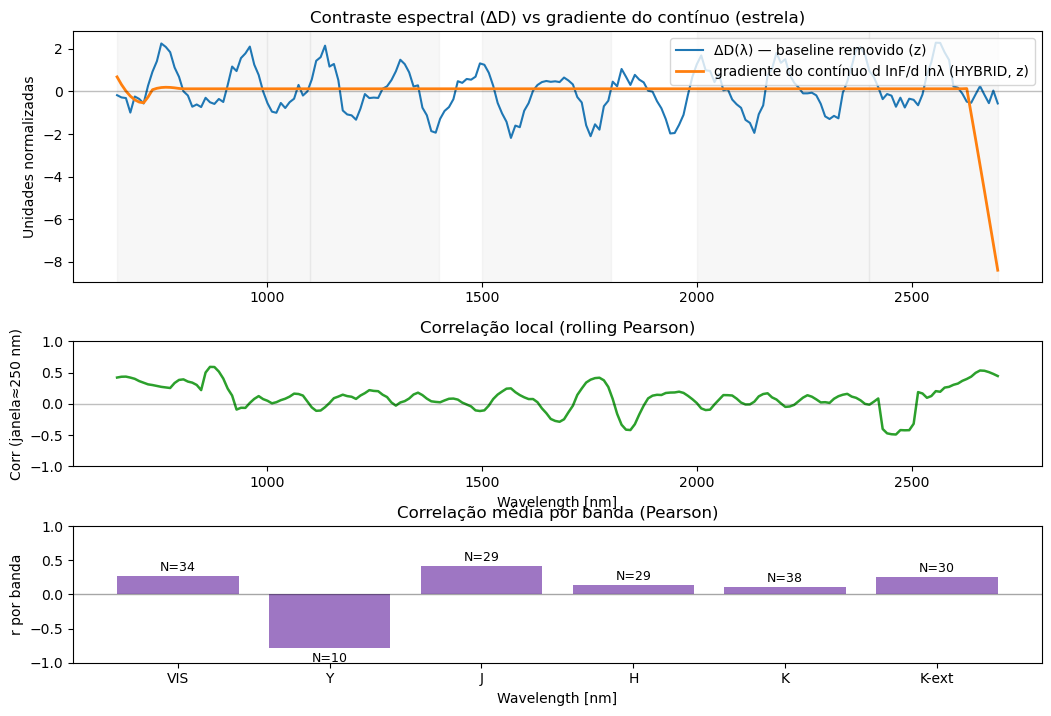

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ====================== KNOBS ======================
# largura da janela do baseline para ΔD (nm)
BASELINE_WIN_NM = 300.0
# janela para suavizar o gradiente (nm)
GRAD_SMOOTH_NM  = 150.0
# janela da correlação local (nm) — rolling Pearson
ROLL_WIN_NM     = 250.0
# bandas espectrais (em nm)
BANDS = {
    "VIS":   (650, 1000),
    "Y":     (1000, 1100),
    "J":     (1100, 1400),
    "H":     (1500, 1800),
    "K":     (2000, 2400),
    "K-ext": (2400, 2700),
}
# ==================================================

def _rolling_median(x_nm: np.ndarray, y: np.ndarray, win_nm: float) -> np.ndarray:
    """ rolling-median em coordenada de λ (nm) com janela em nm """
    x = np.asarray(x_nm, float); y = np.asarray(y, float)
    out = np.full_like(y, np.nan, dtype=float)
    half = 0.5*float(win_nm)
    for i, xc in enumerate(x):
        m = (x >= xc-half) & (x <= xc+half) & np.isfinite(y)
        if np.any(m):
            out[i] = np.nanmedian(y[m])
    return out

def _rolling_mean(x_nm: np.ndarray, y: np.ndarray, win_nm: float) -> np.ndarray:
    x = np.asarray(x_nm, float); y = np.asarray(y, float)
    out = np.full_like(y, np.nan, dtype=float)
    half = 0.5*float(win_nm)
    for i, xc in enumerate(x):
        m = (x >= xc-half) & (x <= xc+half) & np.isfinite(y)
        if np.any(m):
            out[i] = np.nanmean(y[m])
    return out

def _rolling_pearson(x_nm: np.ndarray, y1: np.ndarray, y2: np.ndarray, win_nm: float) -> np.ndarray:
    """ correlação de Pearson em janelas de largura win_nm ao longo de λ """
    x = np.asarray(x_nm, float); y1 = np.asarray(y1, float); y2 = np.asarray(y2, float)
    r = np.full_like(y1, np.nan, dtype=float)
    half = 0.5*float(win_nm)
    for i, xc in enumerate(x):
        m = (x >= xc-half) & (x <= xc+half) & np.isfinite(y1) & np.isfinite(y2)
        if np.count_nonzero(m) >= 8:
            a = y1[m] - np.nanmean(y1[m])
            b = y2[m] - np.nanmean(y2[m])
            da = np.nanstd(a); db = np.nanstd(b)
            if da > 0 and db > 0:
                r[i] = np.nanmean((a/da)*(b/db))
    return r

def band_corr(x_nm: np.ndarray, y1: np.ndarray, y2: np.ndarray, bands: dict[str, tuple[float,float]]):
    """ correlação global por banda (Pearson) + N efetivo """
    out = []
    for name, (lo, hi) in bands.items():
        m = (x_nm >= lo) & (x_nm <= hi) & np.isfinite(y1) & np.isfinite(y2)
        r = np.nan
        if np.count_nonzero(m) >= 8:
            a = y1[m] - np.nanmean(y1[m])
            b = y2[m] - np.nanmean(y2[m])
            da = np.nanstd(a); db = np.nanstd(b)
            if da > 0 and db > 0:
                r = float(np.nanmean((a/da)*(b/db)))
        out.append((name, lo, hi, r, int(np.count_nonzero(m))))
    df = pd.DataFrame(out, columns=["band","lo_nm","hi_nm","r","N"])
    return df

def grad_logF_loglam(lam_nm: np.ndarray, F: np.ndarray) -> np.ndarray:
    """ d ln F / d ln λ usando derivada central robusta (+ suavização opcional) """
    lam = np.asarray(lam_nm, float)
    y = np.asarray(F, float)
    # suaviza levemente o contínuo antes de derivar (evita picos)
    # usa Savitzky-Golay com janela aproximada em nm
    if GRAD_SMOOTH_NM and GRAD_SMOOTH_NM > 0:
        # encontrar número ímpar de pontos ~ GRAD_SMOOTH_NM
        dlam = np.median(np.diff(lam[np.isfinite(lam)]))
        w = max(5, int(round(GRAD_SMOOTH_NM / max(dlam, 1e-6))))
        if w % 2 == 0: w += 1
        if w >= 7 and np.isfinite(y).sum() > w:
            y = savgol_filter(y, window_length=w, polyorder=2, mode="interp")
    # derivada logarítmica
    # d ln F / d ln λ = (λ/F) * dF/dλ
    dF_dlam = np.gradient(y, lam, edge_order=2)
    with np.errstate(divide='ignore', invalid='ignore'):
        g = (lam / np.clip(y, 1e-30, None)) * dF_dlam
    return g

def remove_baseline(x_nm: np.ndarray, deltaD_ppm: np.ndarray, win_nm: float) -> np.ndarray:
    """ remove tendência suave de ΔD por rolling-median """
    base = _rolling_median(x_nm, deltaD_ppm, win_nm=win_nm)
    out = deltaD_ppm - base
    # normaliza para comparar forma (opcional)
    s = np.nanstd(out)
    return out / s if (np.isfinite(s) and s > 0) else out

def main():
    # ---------------------------------------------------------
    # ### [A] ENTRADA DOS DADOS
    # Substitua por suas séries. Você pode:
    #  (a) carregar de arquivo, ou
    #  (b) referenciar arrays já existentes no seu notebook/projeto.
    #
    # EXEMPLO (placeholders):
    # lam_nm: array 1D de comprimentos de onda (nm)
    # deltaD_ppm: profundidade de trânsito (ppm) canal-a-canal (antes de tirar baseline)
    # F_cont: contínuo estelar (ex.: phoenix_continuum_hybrid_global) em mesmo grid lam_nm
    #
    # >>> Troque este bloco pelos seus dados reais <<<
    rng = np.random.default_rng(2)
    lam_nm = np.linspace(650, 2700, 200)  # GRID dummy (troque pelo seu)
    # mock de deltaD com estruturas oscilatórias + ruído
    deltaD_ppm = 5500 + 120*np.sin(2*np.pi*lam_nm/180) + 60*np.cos(2*np.pi*lam_nm/95) + rng.normal(0, 25, lam_nm.size)
    # mock de contínuo suave (monótono) para gradiente
    F_cont = (lam_nm/1000.0)**(-1.2) * np.exp(-(lam_nm-1600.0)**2/(2*1200.0**2))

    # ---------------------------------------------------------
    # [B] PRÉ-PROCESSAMENTO: baseline de ΔD e gradiente do contínuo
    deltaD_z = remove_baseline(lam_nm, deltaD_ppm, win_nm=BASELINE_WIN_NM)
    grad = grad_logF_loglam(lam_nm, F_cont)
    grad_z = (grad - _rolling_mean(lam_nm, grad, win_nm=GRAD_SMOOTH_NM))
    s = np.nanstd(grad_z); 
    grad_z = grad_z / s if (np.isfinite(s) and s > 0) else grad_z

    # ---------------------------------------------------------
    # [C] CORRELAÇÃO LOCAL (rolling)
    r_roll = _rolling_pearson(lam_nm, deltaD_z, grad_z, win_nm=ROLL_WIN_NM)

    # ---------------------------------------------------------
    # [D] CORRELAÇÃO POR BANDA
    df_bands = band_corr(lam_nm, deltaD_z, grad_z, BANDS)
    print("\n=== Correlação por banda (Pearson) ===")
    print(df_bands.to_string(index=False, float_format=lambda v: f"{v:.3f}"))

    # ---------------------------------------------------------
    # [E] PLOTS
    fig = plt.figure(figsize=(12.5, 8.2))
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.1, 1.2], hspace=0.35)

    # Topo: curvas normalizadas
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(lam_nm, deltaD_z, lw=1.5, label="ΔD(λ) — baseline removido (z)", color="#1f77b4")
    ax0.plot(lam_nm, grad_z,   lw=2.0, label="gradiente do contínuo d lnF/d lnλ (HYBRID, z)", color="#ff7f0e")
    ax0.axhline(0, lw=1, color='k', alpha=0.25)
    ax0.set_ylabel("Unidades normalizadas")
    ax0.set_title("Contraste espectral (ΔD) vs gradiente do contínuo (estrela)")
    ax0.legend(loc="upper right", frameon=True)

    # Meio: correlação rolling
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    ax1.plot(lam_nm, r_roll, lw=1.8, color="#2ca02c")
    ax1.axhline(0, lw=1, color='k', alpha=0.25)
    ax1.set_ylim(-1.0, 1.0)
    ax1.set_ylabel(f"Corr (janela≈{ROLL_WIN_NM:.0f} nm)")
    ax1.set_title("Correlação local (rolling Pearson)")

    # Fundo: barras por banda
    ax2 = fig.add_subplot(gs[2, 0])
    names = df_bands["band"].tolist()
    rvals = df_bands["r"].to_numpy()
    bars = ax2.bar(names, rvals, color="#9467bd", alpha=0.9)
    ax2.axhline(0, lw=1, color='k', alpha=0.35)
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_ylabel("r por banda")
    ax2.set_title("Correlação média por banda (Pearson)")

    # anotar N por banda acima das barras
    for rect, N in zip(bars, df_bands["N"].tolist()):
        ax2.text(rect.get_x() + rect.get_width()/2, rect.get_height() + (0.03 if rect.get_height()>=0 else -0.06),
                 f"N={N}", ha='center', va='bottom' if rect.get_height()>=0 else 'top', fontsize=9)

    # indicar visualmente as bandas no painel de cima
    for (name, (lo, hi)) in BANDS.items():
        ax0.axvspan(lo, hi, color='grey', alpha=0.06, zorder=0)

    ax2.set_xlabel("Wavelength [nm]")
    ax1.set_xlabel("Wavelength [nm]")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
